In [1]:
import pandas as pd
import requests
import random
import time
import matplotlib.pyplot as plt

In [2]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0",
    "Accept-Language": 'en-US,en;q=0.9',
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Referer": "https://tiki.vn/",
    "From": "",
    "af-ac-enc-dat": "",
    "x-api-source": "pc"
}

### EXTRACT SUB CATEGORY

In [ ]:
URL = "https://api.tiki.vn/raiden/v2/menu-config?platform=desktop"
response = requests.get(URL, headers=HEADERS)
time.sleep(random.uniform(3.2, 8.7))
if response.status_code == 200:
    data = response.json()
else:
    print("Failed to fetch data:", response.status_code)
    
group = data["menu_block"]["items"]
group_list = []
for group in group:
    link = group["link"]
    group_id = link.split("/")[-1][1:]
    text = group["text"]
    
    if group_id in ["1846", "1789"]:
        group_list.append([group_id, text])

group = pd.DataFrame(group_list, columns=["GroupID", "Name"])

In [ ]:
category_list = []
for group_id, group_name in zip(group["GroupID"], group["Name"]):
    parent_url = f"https://tiki.vn/api/v2/categories?parent_id={group_id}"
    parent_response = requests.get(parent_url, headers=HEADERS)
    time.sleep(random.uniform(3.2, 8.7))
    if parent_response.status_code == 200:
        parent_data = parent_response.json()
        if not parent_data["data"]:
            category_list.append([group_id, group_name, None, None, None, None, None, None])
        else:
            for parent_category in parent_data["data"]:
                parent_id = parent_category["id"]
                parent_name = parent_category["name"]
                
                child_url = f"https://tiki.vn/api/v2/categories?parent_id={parent_id}"
                child_response = requests.get(child_url, headers=HEADERS)
                time.sleep(random.uniform(3.2, 8.7))
                
                if child_response.status_code == 200:
                    child_data = child_response.json()
                    if not child_data["data"]:
                        category_list.append([group_id, group_name, parent_id, parent_name, None, None, None, None])
                    else:
                        for child_category in child_data["data"]:
                            child_id = child_category["id"]
                            child_name = child_category["name"]
                            
                            type_url = f"https://tiki.vn/api/v2/categories?parent_id={child_id}"
                            type_response = requests.get(type_url, headers=HEADERS)
                            time.sleep(random.uniform(3.2, 8.7))
                            
                            if type_response.status_code == 200:
                                type_data = type_response.json()
                                if type_data["data"]:
                                    for type_item in type_data["data"]:
                                        type_id = type_item.get("id")
                                        type_name = type_item.get("name")
                                        category_list.append([group_id, group_name, parent_id, parent_name, child_id, child_name, type_id, type_name])
                                else:
                                    category_list.append([group_id, group_name, parent_id, parent_name, child_id, child_name, None, None])

category_df = pd.DataFrame(category_list, columns=["GroupID", "GroupName", "MasterCategoryID", "MasterCategoryName", "CategoryID", "CategoryName", "SubCategoryID", "SubCategoryName"])

In [ ]:
def remove_single_category(df):
    # Group the DataFrame by MasterCategoryID and count the unique CategoryID values
    category_counts = df.groupby('MasterCategoryID')['CategoryID'].nunique()
    
    # Create a mask for MasterCategoryIDs with only one CategoryID
    single_category_mask = category_counts == 1
    
    # Drop the CategoryID and CategoryName columns for rows where there is only one CategoryID
    df.loc[df['MasterCategoryID'].isin(single_category_mask[single_category_mask].index), ['CategoryID', 'CategoryName']] = [None, None]
    
    return df
  
cleaned_df = remove_single_category(category_df)

def transform_category(row):
    # Handle MasterCategory and Category
    if pd.isna(row['CategoryID']):
        master_category_id = row['MasterCategoryID']
        master_category_name = row['MasterCategoryName']
        category_id = row['MasterCategoryID']
        category_name = row['MasterCategoryName']
        is_category = 0
    else:
        master_category_id = row['MasterCategoryID']
        master_category_name = row['MasterCategoryName']
        category_id = row['CategoryID']
        category_name = row['CategoryName']
        is_category = 1

    # Handle SubCategory
    if pd.isna(row['SubCategoryID']):
        sub_category_id = category_id
        sub_category_name = category_name
        is_sub_category = 0
    else:
        sub_category_id = row['SubCategoryID']
        sub_category_name = row['SubCategoryName']
        is_sub_category = 1

    return pd.Series([
        master_category_id, master_category_name, category_id, category_name,
        is_category, sub_category_id, sub_category_name, is_sub_category
    ])
    
category_df[['MasterCategoryID', 'MasterCategoryName', 'CategoryID', 'CategoryName',
             'isCategory', 'SubCategoryID', 'SubCategoryName', 'isSubCategory']] = category_df.apply(transform_category, axis=1, result_type='expand')

In [ ]:
category_df["GroupID"] = category_df["GroupID"].astype(int)
category_df["MasterCategoryID"] = category_df["MasterCategoryID"].astype(int)
category_df["CategoryID"] = category_df["CategoryID"].astype(int)
category_df["SubCategoryID"] = category_df["SubCategoryID"].astype(int)


master_category = category_df[["MasterCategoryID", "GroupID", "MasterCategoryName"]].drop_duplicates()
master_category = master_category.rename(columns={"MasterCategoryName": "Name"})

category = category_df[["CategoryID", "MasterCategoryID", "CategoryName", "isCategory"]].drop_duplicates()
category = category.rename(columns={"CategoryName": "Name"})

sub_category = category_df[["SubCategoryID", "CategoryID", "SubCategoryName", "isSubCategory"]].drop_duplicates()
sub_category = sub_category.rename(columns={"SubCategoryName": "Name"})

In [ ]:
def retrieve_product_ids(sub_category_id):
    base_url = "https://tiki.vn/api/personalish/v1/blocks/listings"
    PARAMS = {"category": sub_category_id, "page": 1}
    response = requests.get(base_url, headers=HEADERS, params=PARAMS)
    time.sleep(random.uniform(3.2, 8.7))
    data = response.json()
    total_page = data["paging"]["last_page"]

    # Fetch data from each page
    product_data = []
    for page in range(1, total_page + 1):
        PARAMS = {"category": sub_category_id, "page": page}
        response = requests.get(base_url, headers=HEADERS, params=PARAMS)
        time.sleep(random.uniform(3.2, 8.7))
        data = response.json()
        for item in data["data"]:
            product_id = item["id"]
            brand_name = item.get("brand_name", None)  # Use .get() with a default value in case brand_name is missing
            product_data.append({"product_id": product_id, "brand_name": brand_name})

    return product_data

product_df = []

for sub_category_id in sub_category["SubCategoryID"]:
    product_data = retrieve_product_ids(sub_category_id)
    for product in product_data:
        product_df.append([sub_category_id, product["product_id"], product["brand_name"]])
    
product_df = pd.DataFrame(product_df, columns=["SubCategoryID", "ProductID", "BrandName"])

In [3]:
# # Save it to CSV
product_df = pd.read_csv("data/product_id.csv")

In [4]:
# Count the number of ProductID by BrandName
brand_counts = product_df["BrandName"].value_counts()
brand_counts.head(10)

BrandName
HP         501
Dell       334
Samsung    311
Apple       15
Name: count, dtype: int64

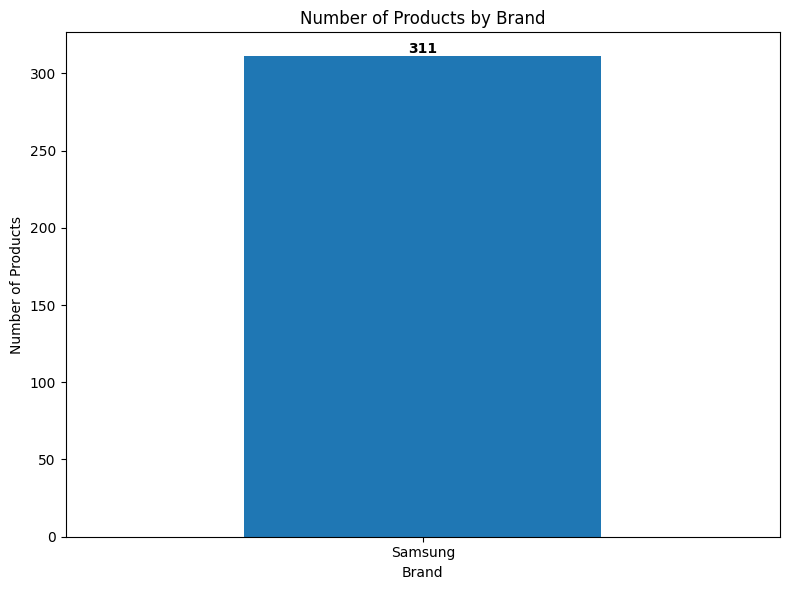

In [5]:
# brands = ['Apple', 'Samsung', 'Dell', 'HP']
brands = ['Samsung']
brand_counts = brand_counts[brands]

fig, ax = plt.subplots(figsize=(8, 6))
brand_counts.plot(kind='bar', ax=ax)

for i, v in enumerate(brand_counts):
    ax.text(i, v, str(v), color='black', fontweight='bold', horizontalalignment='center', verticalalignment='bottom')

plt.title('Number of Products by Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Products')

plt.xticks(range(len(brands)), brands, rotation=0)

plt.tight_layout()
plt.show()

In [8]:
product_df = product_df[product_df['BrandName'].isin(brands)]
product_df

,SubCategoryID,ProductID,BrandName
3,1795,197966909,Samsung
4,1795,213931247,Samsung
5,1795,247730209,Samsung
6,1795,244355503,Samsung
7,1795,273640492,Samsung
...,...,...,...
1154,12298,16396285,Samsung
1155,12298,124483882,Samsung
1156,12298,16613522,Samsung
1157,12298,72288260,Samsung


In [9]:
product_df.to_csv("temp.csv", index=False)

### RETRIEVE PRODUCT DATA

In [ ]:
# filtered_df = pd.read_csv("data/product_id.csv")

In [10]:
product_data_list = []

for _, row in product_df.iterrows():
    sub_category_id = row['SubCategoryID']
    product_id = row['ProductID']

    URL = f"https://tiki.vn/api/v2/products/{product_id}"
    PARAMS = {}

    response = requests.get(URL, headers=HEADERS, params=PARAMS)
    time.sleep(random.uniform(3.2, 4.7))
    
    data = response.json()

    product_data = {
        'product_id': data['id'],
        'product_name': data.get('name', None),
        'product_url': data.get('short_url', None),
        'pricing_current': data.get('price', None),
        'pricing_original': data.get('original_price', None),
        'product_image_url': data.get('thumbnail_url', None),
        'inventory_status': data.get('inventory_status', None),
        'inventory_type': data.get('inventory_type', None),
        'created_date': data.get('day_ago_created', None),
        'quantity_sold': data.get('all_time_quantity_sold', None),
        'brand_id': data.get('brand', {}).get('id', None),
        'brand_name': data.get('brand', {}).get('name', None),
        'brand_slug': data.get('brand', {}).get('slug', None),
        'seller_id': data.get('current_seller', {}).get('id', 0) if data.get('current_seller') else 0,
        'seller_name': data.get('current_seller', {}).get('name', 0) if data.get('current_seller') else 0,
        'seller_link': data.get('current_seller', {}).get('link', 0) if data.get('current_seller') else 0,
        'seller_image_url': data.get('current_seller', {}).get('logo', 0) if data.get('current_seller') else 0,
        'category_id': data['categories']['id'] if data['categories']['is_leaf'] else data['breadcrumbs'][-2]['category_id'],
        'sub_category_id': sub_category_id,
        'brand_name': row['BrandName']
    }

    product_data_list.append(product_data)

print(f"Success fetching data for {len(product_data_list)} products")
product_df = pd.DataFrame(product_data_list, columns=['product_id', 'product_name', 'product_url', 'pricing_current', 'pricing_original', 'product_image_url', 'inventory_status', 'inventory_type', 'created_date', 'quantity_sold', 'brand_id', 'brand_name', 'brand_slug', 'seller_id', 'seller_name', 'seller_link', 'seller_image_url', 'category_id', 'sub_category_id', 'brand_name'])
product_df.to_csv("product_data_2.csv", index=False, encoding='utf-8-sig')
product_df.head(10)

Success fetching data for 311 products


,product_id,product_name,product_url,pricing_current,pricing_original,product_image_url,inventory_status,inventory_type,created_date,quantity_sold,brand_id,brand_name,brand_slug,seller_id,seller_name,seller_link,seller_image_url,category_id,sub_category_id,brand_name
0,197966909,Điện Thoại Samsung A04s 4GB/64GB - Hàng Chính ...,https://tiki.vn/product-p197966909.html?spid=1...,2629000,3990000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,595,86.0,18802,Samsung,samsung,29952,Hồng Hạnh Mobile,https://tiki.vn/cua-hang/hong-hanh-mobile,https://vcdn.tikicdn.com/ts/seller/e8/09/c9/d7...,1795,1795,Samsung
1,213931247,Điện thoại Samsung Galaxy A04 (3GB / 32GB) - H...,https://tiki.vn/product-p213931247.html?spid=2...,2400000,2400000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,490,NaN,18802,Samsung,samsung,11119,GIA DỤNG VIỆT,https://tiki.vn/cua-hang/nguyen-van-thang,47/20/4f/9800dd1b2ca67db582030ded1dc700b3.png,1795,1795,Samsung
2,247730209,Điện thoại Samsung Galaxy A34 5G (8GB/128GB) -...,https://tiki.vn/product-p247730209.html?spid=2...,7164000,7164000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,418,3.0,18802,Samsung,samsung,11119,GIA DỤNG VIỆT,https://tiki.vn/cua-hang/nguyen-van-thang,47/20/4f/9800dd1b2ca67db582030ded1dc700b3.png,1795,1795,Samsung
3,244355503,Điện thoại Samsung Galaxy A04s (4GB/64BG) - Hà...,https://tiki.vn/product-p244355503.html?spid=2...,3990000,3990000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,424,NaN,18802,Samsung,samsung,259954,MT Smart Official Store,https://tiki.vn/cua-hang/mt-smart,https://vcdn.tikicdn.com/ts/seller/7e/c4/5b/97...,1795,1795,Samsung
4,273640492,Điện Thoại Samsung Galaxy A05 (6GB/128GB) - Hà...,https://tiki.vn/product-p273640492.html?spid=2...,3450000,3450000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,144,1.0,18802,Samsung,samsung,11119,GIA DỤNG VIỆT,https://tiki.vn/cua-hang/nguyen-van-thang,47/20/4f/9800dd1b2ca67db582030ded1dc700b3.png,1795,1795,Samsung
5,245770363,Điện thoại Samsung Galaxy A04e (3GB/32GB) - Hà...,https://tiki.vn/product-p245770363.html?spid=2...,2325000,2325000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,424,NaN,18802,Samsung,samsung,11119,GIA DỤNG VIỆT,https://tiki.vn/cua-hang/nguyen-van-thang,47/20/4f/9800dd1b2ca67db582030ded1dc700b3.png,1795,1795,Samsung
6,262589811,Điện thoại Samsung Galaxy A24 (6GB/128GB) - Hà...,https://tiki.vn/product-p262589811.html?spid=2...,6084000,6084000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,339,NaN,18802,Samsung,samsung,11119,GIA DỤNG VIỆT,https://tiki.vn/cua-hang/nguyen-van-thang,47/20/4f/9800dd1b2ca67db582030ded1dc700b3.png,1795,1795,Samsung
7,255866251,Điện Thoại Samsung A14 4GB/128GB - Hàng Chính ...,https://tiki.vn/product-p255866251.html?spid=2...,3349000,4490000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,357,NaN,18802,Samsung,samsung,179232,THẮNG THAO MOBILE,https://tiki.vn/cua-hang/thang-thao-mobile,https://vcdn.tikicdn.com/ts/seller/83/e1/c3/2c...,1795,1795,Samsung
8,253443894,Điện Thoại Samsung Galaxy M14 5G (4GB/128GB) -...,https://tiki.vn/product-p253443894.html?spid=2...,3937000,3937000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,363,1.0,18802,Samsung,samsung,11119,GIA DỤNG VIỆT,https://tiki.vn/cua-hang/nguyen-van-thang,47/20/4f/9800dd1b2ca67db582030ded1dc700b3.png,1795,1795,Samsung
9,270636882,Điện Thoại Samsung M14 5G 4GB/64GB - Hàng Chín...,https://tiki.vn/product-p270636882.html?spid=2...,2849000,4990000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,288,2.0,18802,Samsung,samsung,29952,Hồng Hạnh Mobile,https://tiki.vn/cua-hang/hong-hanh-mobile,https://vcdn.tikicdn.com/ts/seller/e8/09/c9/d7...,1795,1795,Samsung


### RETRIEVE FEEDBACK DATA

In [14]:
feedback_data_list = []
for _, row in product_df.iterrows():
    sub_category_id = row['sub_category_id']
    product_id = row['product_id']
    URL = "https://tiki.vn/api/v2/reviews"
    PARAMS = {"limit": 20, "spid": sub_category_id, "product_id": product_id}

    # Get the total number of pages
    response = requests.get(URL, headers=HEADERS, params=PARAMS)
    data = response.json()
    total_pages = data.get("paging", {}).get("last_page", 1)

    # Fetch data from each page
    for page in range(1, total_pages + 1):
        PARAMS["page"] = page
        response = requests.get(URL, headers=HEADERS, params=PARAMS)
        time.sleep(random.uniform(3.2, 4.7))
        data = response.json()

        stars = data.get("stars", {})
        OneStarCount = stars.get("1", {}).get("count", 0)
        TwoStarCount = stars.get("2", {}).get("count", 0)
        ThreeStarCount = stars.get("3", {}).get("count", 0)
        FourStarCount = stars.get("4", {}).get("count", 0)
        FiveStarCount = stars.get("5", {}).get("count", 0)
        reviews_count = data.get("reviews_count", 0)
        review_data = data.get("data", [])

        for review in review_data:
            review_id = review.get("id")
            review_title = review.get("title")
            review_content = review.get("content")
            review_upvote = review.get("thank_count", 0)
            review_rating = review.get("rating")
            review_created_at = review.get("created_at")
            reviewer = review.get("created_by", {})

            if reviewer is not None:
                user_id = reviewer.get("id")
                username = reviewer.get("name")
                joined_time = reviewer.get("created_time")
                total_reviews = reviewer.get("contribute_info", {}).get("summary", {}).get("total_review", 0)
                total_upvotes = reviewer.get("contribute_info", {}).get("summary", {}).get("total_thank", 0)
            else:
                user_id = None
                username = None
                joined_time = None
                total_reviews = 0
                total_upvotes = 0

            feedback_data_list.append([OneStarCount, TwoStarCount, ThreeStarCount, FourStarCount, FiveStarCount,
                                       reviews_count, review_id, review_title, review_content, review_upvote,
                                       review_rating, review_created_at, user_id, username, joined_time,
                                       total_reviews, total_upvotes])

    print(f"Success fetching data for {len(feedback_data_list)} feedbacks")

feedback_df = pd.DataFrame(feedback_data_list, columns=["OneStarCount", "TwoStarCount", "ThreeStarCount", "FourStarCount",
                                                        "FiveStarCount", "reviews_count", "review_id", "review_title",
                                                        "review_content", "review_upvote", "review_rating",
                                                        "review_created_at", "user_id", "username", "joined_time",
                                                        "total_reviews", "total_upvotes"])

feedback_df.to_csv("feedback_data_2.csv", index=False, encoding='utf-8-sig')
feedback_df.head(10)

Success fetching data for 21 feedbacks
Success fetching data for 21 feedbacks
Success fetching data for 40 feedbacks
Success fetching data for 40 feedbacks
Success fetching data for 41 feedbacks
Success fetching data for 41 feedbacks
Success fetching data for 41 feedbacks
Success fetching data for 41 feedbacks
Success fetching data for 41 feedbacks
Success fetching data for 42 feedbacks
Success fetching data for 43 feedbacks
Success fetching data for 43 feedbacks
Success fetching data for 43 feedbacks
Success fetching data for 46 feedbacks
Success fetching data for 46 feedbacks
Success fetching data for 96 feedbacks
Success fetching data for 96 feedbacks
Success fetching data for 96 feedbacks
Success fetching data for 98 feedbacks
Success fetching data for 98 feedbacks
Success fetching data for 99 feedbacks
Success fetching data for 99 feedbacks
Success fetching data for 99 feedbacks
Success fetching data for 99 feedbacks
Success fetching data for 99 feedbacks
Success fetching data for

,OneStarCount,TwoStarCount,ThreeStarCount,FourStarCount,FiveStarCount,reviews_count,review_id,review_title,review_content,review_upvote,review_rating,review_created_at,user_id,username,joined_time,total_reviews,total_upvotes
0,0,0,0,4,17,21,18879992,Cực kì hài lòng,"Hàng giao nhanh, máy nhận rất vừa ý. Thanks shop",0,5,1677568182,14168087.0,Nguyen Lam Tuan,2019-09-25 11:07:51,9,0
1,0,0,0,4,17,21,19322768,Cực kì hài lòng,Sản phẩm đúng như mô tả máy đẹp,0,5,1687602309,12962374.0,Tuan Trinhlong,2019-07-18 10:08:23,1,0
2,0,0,0,4,17,21,18418231,Cực kì hài lòng,"Rất đẹp, đúng màu giao hàng nhanh. Rất hài lòn...",2,5,1671012479,24031573.0,Trần Xuân Linh,2021-10-11 10:32:31,3,2
3,0,0,0,4,17,21,19268377,Cực kì hài lòng,"Hàng chất lượng, đúng y như hình , giao hàng n...",0,5,1686107860,13441949.0,Huỳnh Vân Anh,2019-08-14 19:13:33,3,0
4,0,0,0,4,17,21,19161975,Cực kì hài lòng,"May moi 100%.Cám ỏn shop giao nhanh,Đúng nhủ s...",0,5,1683283670,5772686.0,hoang anh tuan,2017-09-14 17:24:24,64,23
5,0,0,0,4,17,21,19851384,Cực kì hài lòng,,0,5,1713801167,20203802.0,Bui tuan anh,2021-02-04 17:55:03,4,0
6,0,0,0,4,17,21,19823760,Hài lòng,,0,4,1711637448,27209044.0,tuan do,2022-03-29 23:05:12,4,0
7,0,0,0,4,17,21,19258573,Cực kì hài lòng,"Vẫn ủng hộ shop, đã mua rất nhiều sp, rất hài ...",0,5,1685848514,8733968.0,Lư Hồng Ân,2018-11-02 21:12:19,30,2
8,0,0,0,4,17,21,18027265,Cực kì hài lòng,Hàng đóng gói cẩn thận,0,5,1666511452,5813918.0,Quyên Đoàn,2017-09-24 21:00:59,30,0
9,0,0,0,4,17,21,19710123,Hài lòng,,0,4,1704348311,1309048.0,Hai Mai Nguyen,2016-04-17 18:48:20,49,23
